In [114]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

## DataSet Preperation

In [115]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Dataset checking

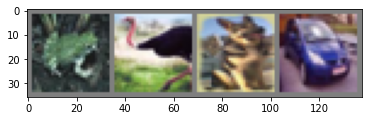

 frog  bird   dog   car


In [116]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [117]:
print(type(images))
print(images.shape)
print(type(labels))
print(labels.shape)
print(labels)

<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([4])
tensor([6, 2, 5, 1])


## Model Architecture + Drop out

In [126]:
class MLPModel(nn.Module):
    def __init__(self,in_dim,out_dim,hid_dim,n_layer,act,p):
        super(MLPModel,self).__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.hid_dim=hid_dim
        self.n_layer=n_layer
        self.act=act
        self.p=p
        
        self.fc=nn.Linear(self.in_dim, self.hid_dim)
        self.dropout=nn.Dropout(self.p)
        self.linears=nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim,self.hid_dim))
        self.fc2=nn.Linear(self.hid_dim,self.out_dim)
        
        if self.act=='relu':
            self.act=nn.ReLU()
        
    def forward(self,x):
        x=self.act(self.fc(x))
        for fc in self.linears:
            x=self.dropout(act(fc(x)))
        x=self.fc2(x)
        return x

In [128]:
net=MLPModel(3072,10,100,4,'relu',0.5)

In [129]:
print(model)

MLPModel(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


### Experiment

In [131]:
def experiment(args):
    net=MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    print(net)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    
    for epoch in range(args.epoch):  # loop over the dataset multiple times

        # ===== Train ===== #
        running_loss = 0.0
        train_loss=0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #print(inputs.shape)
            inputs=inputs.view(-1,3072)
            inputs=inputs.cuda()
            labels=labels.cuda()
            #print(inputs.shape)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss+=loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        # ===== Validation ===== #
        correct = 0
        total = 0
        val_loss=0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images=images.view(-1,3072)
                
                images=images.cuda()
                labels=labels.cuda()
                # calculate outputs by running images through the network
                outputs = net(images)
                loss = criterion(outputs, labels)
                val_loss+=loss.item()

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss=val_loss/len(valloader)
            #print(val_loss)
            val_acc=100 * correct / total
            print('Epoch: {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch,train_loss,val_loss,val_acc))
                
     # ===== Evaluation =====#
    correct=0
    total=0
    with torch.no_grad():
        for data in testloader:
            images,labels=data
            images=images.view(-1,3072)
            images=images.cuda()
            labels=labels.cuda()
            outputs=net(inputs)
            _, predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
                
        test_acc=100*correct/total
            
   
    

In [132]:
import argparse
parser=argparse.ArgumentParser()
args=parser.parse_args("")

In [ ]:
seed=123
np.random.seed(seed)
torch.manual_seed(seed)

args.n_layer=5
args.in_dim=3072
args.out_dim=10
args.hid_dim=100
args.act='relu'
args.lr=0.001
args.mm=0.9
args.epoch=2
args.p=0.5

list_var1=[4,5,6]
list_var2=[50,100,150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer=var1
        args.hid_dim=var2
        result=experiment(args)
        print(result)

MLP(
  (fc): Linear(in_features=3072, out_features=50, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (act): ReLU()
)
[1,  2000] loss: 2.199
[1,  4000] loss: 1.892
[1,  6000] loss: 1.789
[1,  8000] loss: 1.725
[1, 10000] loss: 1.655
Epoch: 0, Train Loss: 18519.67625796795, Val Loss: 1.7177172367572784, Val Acc: 38.35
[2,  2000] loss: 1.625
[2,  4000] loss: 1.603
[2,  6000] loss: 1.589
[2,  8000] loss: 1.568
[2, 10000] loss: 1.564
Epoch: 1, Train Loss: 15896.74414524436, Val Loss: 1.568799816274643, Val Acc: 44.27
